In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# for manipulations
import numpy as np
import pandas as pd

# for data visualizations
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fast')

In [3]:
#read the dataset
data=pd.read_csv('data.csv')
data.head()

,Item(s),Item 1,Item 2,Item 3,Item 4,Item 5,Item 6,Item 7,Item 8,Item 9,...,Item 23,Item 24,Item 25,Item 26,Item 27,Item 28,Item 29,Item 30,Item 31,Item 32
0,4,citrus fruit,semi-finished bread,margarine,ready soups,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3,tropical fruit,yogurt,coffee,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,whole milk,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,pip fruit,yogurt,cream cheese,meat spreads,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,other vegetables,whole milk,condensed milk,long life bakery product,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
#Shape of dataset
print(f'Shape of data: {data.shape[0]} rows and {data.shape[1]} columns')

Shape of data: 9835 rows and 33 columns


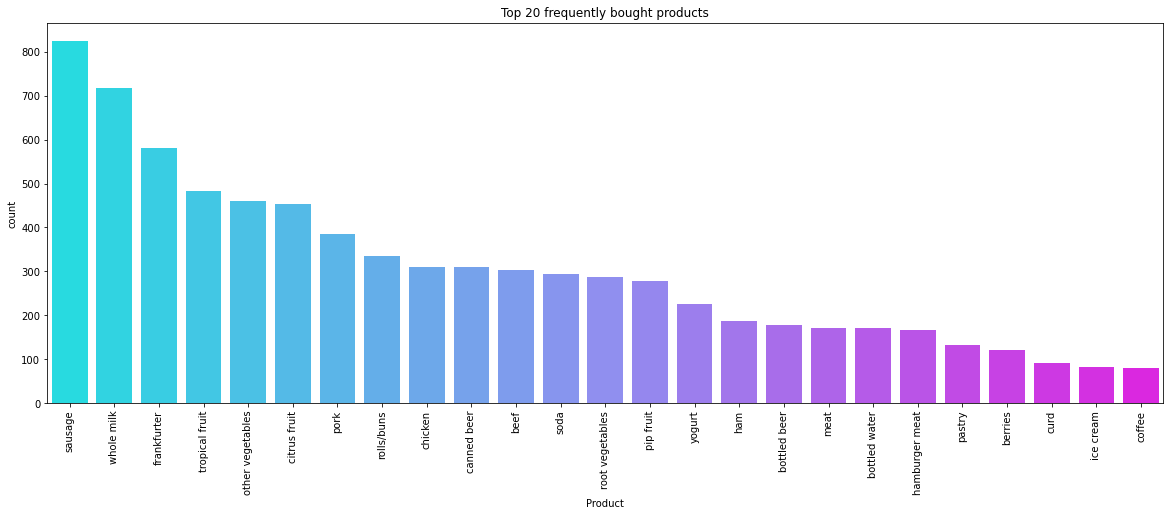

In [5]:
#Top 20 frequently buying items by customer
plt.rcParams['figure.figsize']=20,7
sns.countplot(data=data, x=data['Item 1'],
             order = data['Item 1'].value_counts().head(25).index,
             palette='cool')
plt.xticks(rotation=90)
plt.xlabel('Product')
plt.title('Top 25 frequently bought products')
plt.show()

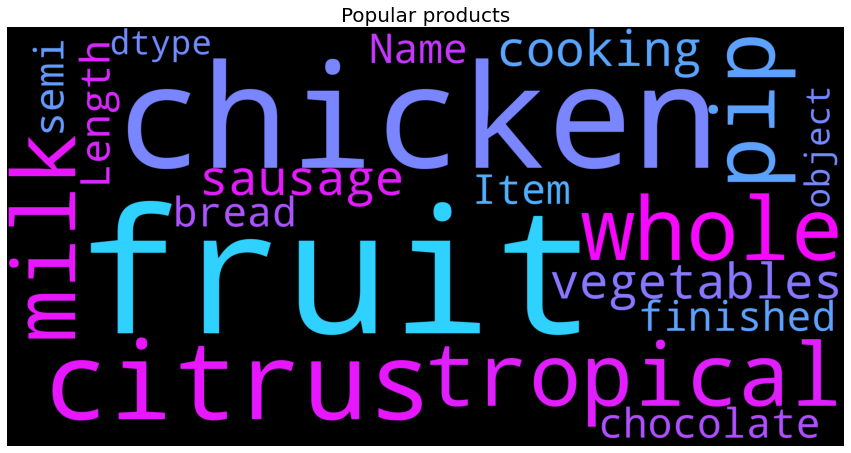

In [6]:
#let's check popular products
from wordcloud import WordCloud

plt.rcParams['figure.figsize'] = (15, 15)
wordcloud = WordCloud(width = 2000,  height = 1000, max_words = 20, colormap='cool').generate(str(data['Item 1']))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Popular products',fontsize = 20)
plt.show()

In [7]:
#let's create a list of list of transaction
records = []
for i in range(0, len(data)):
    records.append([str(data.values[i,j]) for j in range(1, data.values[i, 0]+1)])

In [8]:
#Let's analyze the no. of items wrt each transaction
counts = [len(record) for record in records]
print(f'50 percent of the transactions are having items below or equal to {np.quantile(counts, .5)} only')
print(f'particular transaction having a maximum of {np.quantile(counts, 1)} items in it')

50 percent of the transactions are having items below or equal to 3.0 only
particular transaction having a maximum of 32 items in it


In [9]:
#Let's encode the created list of list like onehot encode

from mlxtend.preprocessing import TransactionEncoder

te = TransactionEncoder()
onehot = te.fit_transform(records)
onehot = pd.DataFrame(onehot, columns = te.columns_)

In [10]:
#Shape of encoded onehot dataset
print(f'Shape of encoded data: {onehot.shape[0]} rows and {onehot.shape[1]} columns')

Shape of encoded data: 9835 rows and 169 columns


In [11]:
#Due to complexity we are reducing the no of items by selecting particular items alone
onehot = onehot.loc[:, ['bottled beer', 'bottled water', 'brandy', 'brown bread', 'butter', 'syrup',
                    'sweet spreads', 'beverages', 'berries', 'beef', 'bathroom cleaner', 'baking powder', 'bags',
                    'baby food', 'baby cosmetics', 'Instant food products', 'tea', 'toilet cleaner', 'vinegar', 'waffles', 'whisky',
                    'white bread', 'white wine', 'yogurt', 'zwieback', 'whole milk', 'whipped/sour cream', 'abrasive cleaner']]

In [12]:
#Shape of encoded onehot dataset after reducing no. ofitems
print(f'Shape of encoded data: {onehot.shape[0]} rows and {onehot.shape[1]} columns')

Shape of encoded data: 9835 rows and 28 columns


In [13]:
#Let's generate the frequent itemset using apriori with minimum support of 0.01%
#maximum item per transaction restricted to 3

from mlxtend.frequent_patterns import apriori, association_rules

frequent_itemsets=apriori(onehot, min_support=0.0001, use_colnames=True, max_len=3)
frequent_itemsets

,support,itemsets
0,0.080529,(bottled beer)
1,0.110524,(bottled water)
2,0.004169,(brandy)
3,0.064870,(brown bread)
4,0.055414,(butter)
...,...,...
1006,0.010880,"(whipped/sour cream, whole milk, yogurt)"
1007,0.000712,"(abrasive cleaner, whole milk, yogurt)"
1008,0.000102,"(abrasive cleaner, whipped/sour cream, yogurt)"
1009,0.000203,"(zwieback, whipped/sour cream, whole milk)"


In [14]:
#Generating Association rule with mlxtend's association_rules
rules=association_rules(frequent_itemsets)

In [15]:
rules.shape

(164, 9)

In [16]:
#Pruning the generated rules using multiple filters

targeted_rules = rules[rules['antecedents'] == {'baby food'}].copy()

In [17]:
filtered_rules = targeted_rules[(targeted_rules['confidence'] > 0.85) &
                                (targeted_rules['lift'] > 1.00)]

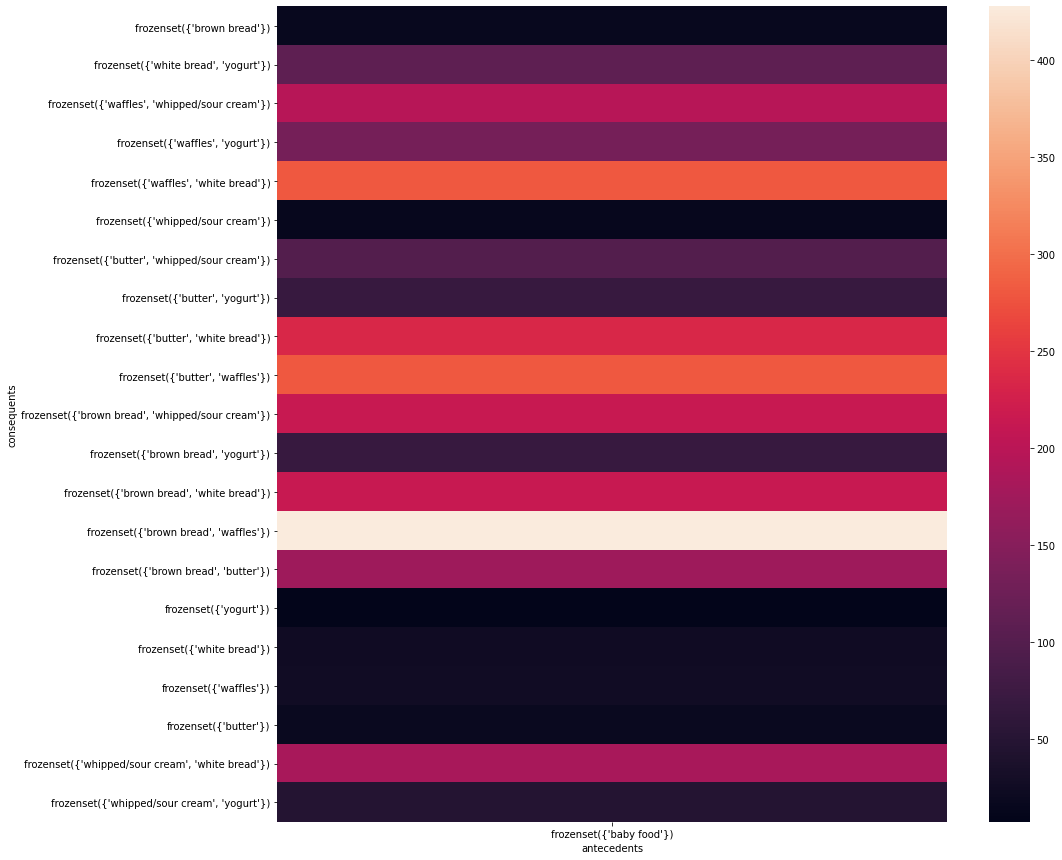

In [18]:
#let's analyse the 'baby foods' relevent consequents

support_table = filtered_rules.pivot(index='consequents', columns='antecedents', values='lift')
sns.heatmap(support_table)

In [19]:
rules['antecedent'] = rules['antecedents'].apply(lambda antecedent: list(antecedent)[0])
rules['consequent'] = rules['consequents'].apply(lambda consequent: list(consequent)[0])
rules['rule'] = rules.index
coords = rules[['antecedent','consequent','rule']]

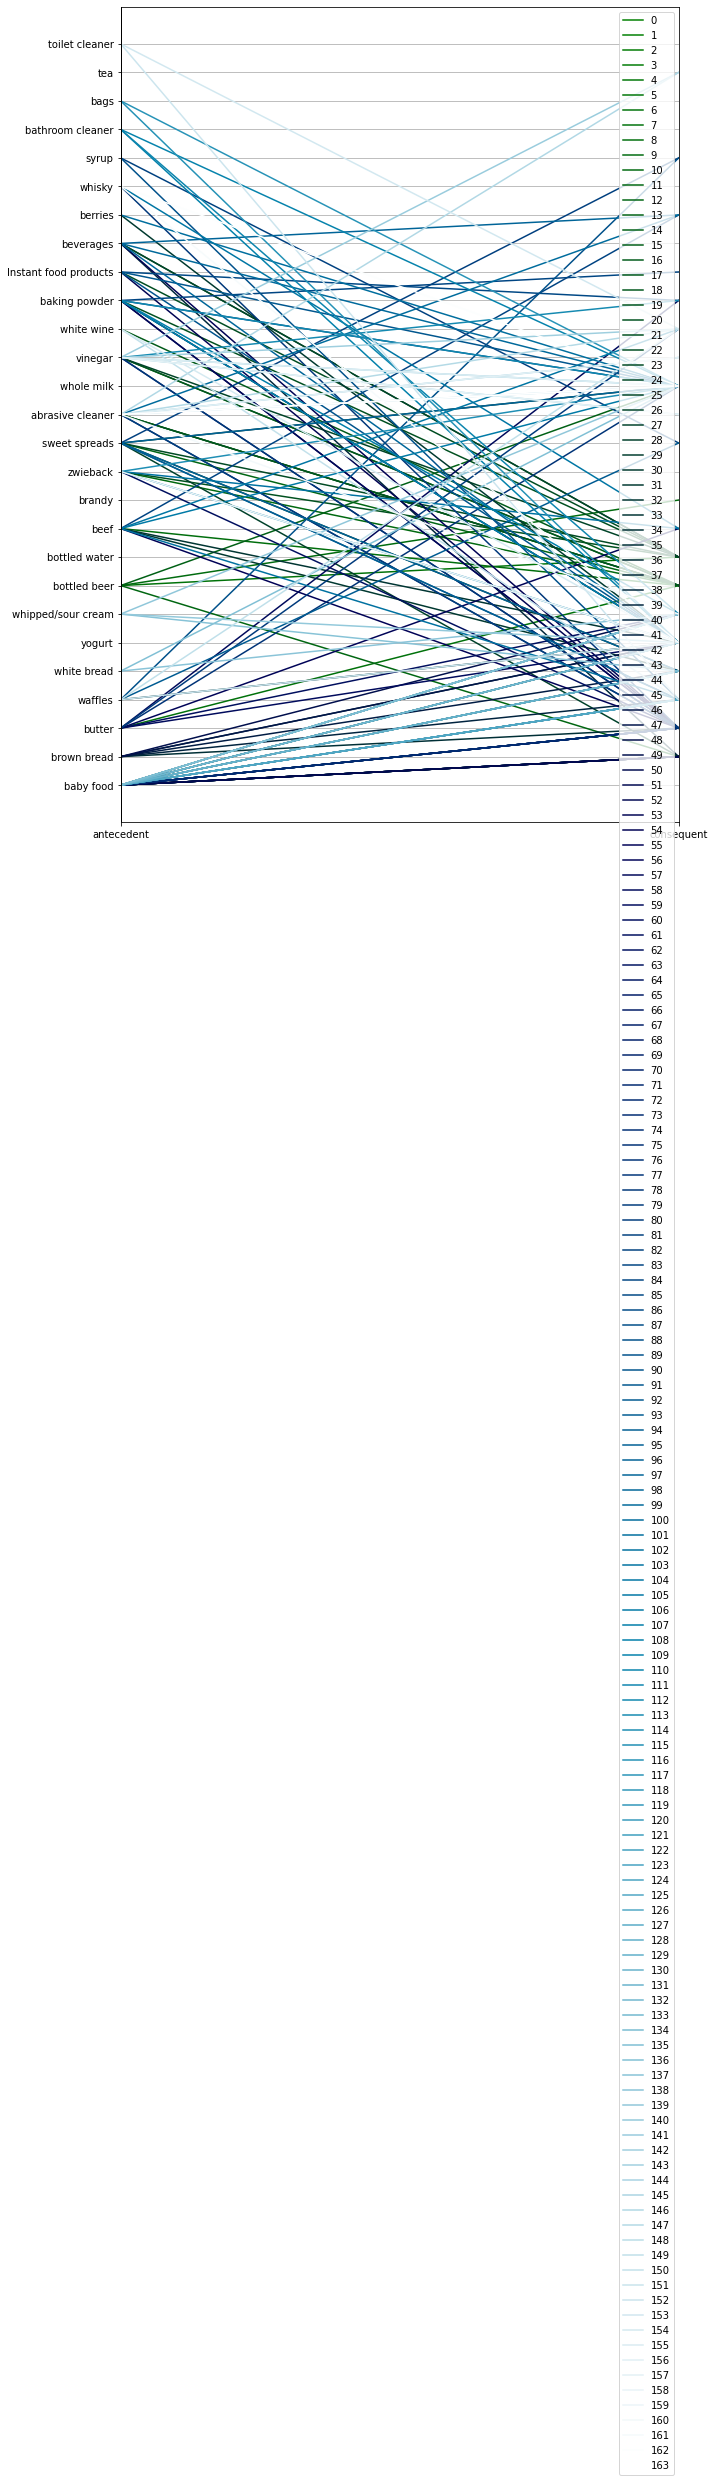

In [20]:
# Generate parallel coordinates plot

from pandas.plotting import parallel_coordinates

plt.rcParams['figure.figsize']=10,15
parallel_coordinates(coords,'rule', colormap = 'ocean')
plt.show()